# Genomic distances with HyperLogLog


### 1. Introduction to the problem of study

The fundamental problem at the core of this study is the need for efficient and accurate methods to analyze genomic data, particularly when dealing with large datasets comprising complete genome assemblies. Genomic distances play a pivotal role in understanding the relationships between different genomes, while cardinality estimation is essential for quantifying the number of unique elements within a genomic dataset. Traditional methods often struggle to cope with the sheer volume and diversity of genomic data, necessitating the exploration of innovative approaches.

In response to this need, the study focuses on three prominent tools—Dashing, Mash, and BinDash—each employing distinct algorithms for sketching and pairwise distance calculations. These tools are applied to a vast dataset of over 87,000 complete genome assemblies obtained from RefSeq. The research aims to comprehensively evaluate the computational efficiency, scalability, and accuracy of these tools under varying conditions, considering different sketch sizes and k-mer lengths.

As part of the investigation, the HyperLogLog (HLL) algorithm is employed for cardinality estimation, offering a novel probabilistic approach to approximate counting in genomic datasets.

### 2.  Brief and general description of the approach and methods used

###### *According to [1], (General understanding of the Hyperloglog concept ):*
A relevant question is put in problems with high volume of data and streaming data: how is it possible to estimate the cardinality of a very large dataset? One popular solution was presented by Philippe Flajolet and G. Nigel Martin, as they have they developed the Flajolet-Martin Algorithm. This algorithm can be ilustrated with a problem of counting the number of visitors of an exhibition, where it is needed to keep record of all names. However, instead of names it would be possible to register the last six digits from the visitor's phone numbers. This would allow us to keep track of the number of zeros in the beginning of the sequence of digits. According to this process, if the longest observed sequence of zeros was $K$, it is likely that the number of visitor would be at least $10^{K}$. Flajolet-Martin Algorithm involves applying a hash function to the sequence of digits, so that a sequence of six ones and zeros would be formed. This way, the probability of getting $K$ zeros in the beginning of the array would be would be $1/2^{K}$, instead of $1/10^{K}$. In the end, the cardinality of an element would be $2^{K}/ф$, where $ф$ if a correction factor, approximately 0.77351.
</br>
However, this method is not very robust, since it is very sensitive to outliers. Throughout the years, three more solutions were proposed to reduced the error. The first was LogLog proposed by Flagolet and Durand, where the values were devided into $m$ "buckets", and instead of considering $K$ for calculating cardinality, the number of leading zeros would be determined by the average of the greatest number of leading zeros per bucket, were the cardinatily would be now $m*2^{(K1+...+Km)/m}/ф$, recuding the standard error. The second improvement was also proposed by Flajolet and Durand - SuperLogLog. This algorithm was essentially the same as before, but descarding the 30% highest values after collection from buckets, which reduces the influence of outliers. For SuperLogLog, the cardinality is $0.7*m*2^\text{avg(smallest 70\% of K)}/ф$, where the error is reduced from the LogLog. HyperLogLog, also proposed by Flajolet, tackles the problem of outliers even better by appling the harmonic mean of all $K$'s from the buckets. The harmonic mean is the inverse of mean of all inverse values of $K$'s. This way, the cardinality of HyperLogLog is $m*2^\text{harmonic mean(Ki)}/ф$.

###### *According to [2] (The paper under study):*

**HyperLogLog Methodology:**

The HyperLogLog $(HLL)$ algorithm is designed for approximate counting in $O(\log^2(\log(n)))$ space. It estimates the cardinality (number of unique elements) in a multiset by using a probabilistic data structure. The main steps involved in the HLL methodology are as follows:

1. **Hashing and Partitioning:**
   - Given a stream of data items, each item is hashed, and the hash values are partitioned based on their most significant bits (prefix).
   - If $(o)$ is an input item and $(h)$ is the hash function, the value $(h(o))$ is partitioned into bit-string prefix $(p)$ and suffix $(q)$.

2. **Register Update:**
   - Each partition corresponds to an array of 8-bit "registers."
   - For each item, the register corresponding to its prefix is updated. The update is based on the maximum leading zero count $(LZC)$ of the suffix $(q)$.
   - The register is set to the greater of its current value and the $(LZC)$.

3. **Combining Estimates:**
   - The estimates from individual registers are combined to obtain an overall cardinality estimate.
   - The harmonic mean is applied to the estimates, and a correction factor is used to refine the result.

4. **Cardinality Estimation:**
   - The final cardinality estimate is derived from the combined register-level estimates.
   - The estimator has a standard error of $(1.03896 \sqrt{m})$, where $(m)$ is the number of registers.

5. **Relationship to MinHash and Bloom Filters:**
   - Informally, modifying HLL to store a simple minimum in each register is similar to a MinHash sketch.
   - A Bloom filter with a single hash function and $(2^x)$ bits is essentially an HLL with an $(x)$-bit hash prefix and single-bit registers.

**Estimation Methods in HyperLogLog:**

1. **Original HLL Method:**
   - Combines register-level estimates using a corrected harmonic mean.
   - Formula: $(E = \frac{\alpha_m m^2}{\sum_{j=1}^{m} 2^{-M_j}})$, where $(\alpha_m)$ is a correction factor, $(M_j)$ is the maximum LZC in register $(j)$ and $(m)$ is the total number of registers.

2. **Refinements in Original HLL:**
   - Linear counting introduced for low cardinality estimates.
   - Addressing saturated counters improves high-cardinality estimates.

3. **Ertl's Improved Estimator:**
   - Assumes uniformly distributed hash function outputs and independent register values.
   - Models register count as a Poisson random variable.
   - Poisson parameter estimation yields the cardinality estimate.

4. **Ertl's Maximum Likelihood Estimator (MLE):**
   - Utilizes uniformity and Poisson assumptions.
   - Finds roots of the derivative of the log-likelihood of the Poisson parameter given register values.
   - Estimate is bounded by harmonic means of per-register estimates.
   - Converges in a small number of steps.

5. **Ertl's Joint MLE:**
   - Directly estimates cardinality of set intersections.
   - Models two sketches, A and B, as a mixture of three components.
   - Jointly estimates Poisson parameters for unique elements in A, unique elements in B, and elements in their intersection.
   - Operates on tallies of relationships (<, =, >) between sketch registers.

6. **Performance Considerations:**
   - Joint MLE is slower than MLE due to increased complexity and linear growth of tallying work with sketch size.
   - Efficient, SIMD-ized inner loops are crucial for comparing HLLs.



### 3. Literature review of the problem and methods

> Indented block



##### *According to [3] :*
#### Main Concept and Context

1. **Genomic Sketching**:
   - Dashing 2 addresses the need for efficient genomic sketching, a technique to condense large genomic datasets into smaller, probabilistic representations (sketches) while retaining key characteristics.

2. **Limitations of Existing Tools**:
   - Traditional tools like Mash and the original Dashing, although effective for datasets with tens of thousands of genomes, struggle with larger datasets, which can reach millions of sequences. Additionally, they do not account for k-mer multiplicities, crucial in quantitative genomic analysis.

3. **K-mer Canonicalization**:
   - In genomic sketching, sequences are transformed into sets of k-mers (length-k substrings). To ensure accurate representation, k-mers are canonicalized, meaning each k-mer is replaced with its reverse complement if the reverse is smaller.

#### Approach and Methodology

1. **SetSketch Data Structure**:
   - Dashing 2 is built on the SetSketch structure, an improvement over HyperLogLog (HLL). SetSketch uses a truncated logarithm of adjustable base, optimizing space utilization in each register.

2. **Multiplicity-Aware Sketching**:
   - Unlike HLL, SetSketch, combined with the ProbMinHash method, supports multiplicity-aware sketching. This feature allows Dashing 2 to handle datasets where the frequency of k-mers is relevant.

3. **Locality-Sensitive Hashing (LSH)**:
   - Dashing 2 integrates LSH to scale all-pairs comparisons for very large inputs, making it highly effective for large-scale sequence comparisons.

4. **Support for Various Sequence Types**:
   - It supports multiple sequence alphabets, including DNA and various protein alphabets, making it adaptable to a wide range of genomic data.

#### Efficiency and Accuracy

1. **Performance in Large Datasets**:
   - Dashing 2 effectively scales to compare millions of sequences, a significant advancement over previous tools.

2. **Enhanced Accuracy**:
   - Dashing 2 shows lower estimation error for Jaccard coefficients and ANI compared to its predecessors and other similar tools. The incorporation of k-mer multiplicities notably improves accuracy.

3. **Comparison Metrics**:
   - It supports various metrics like the Jaccard coefficient, Mash distance, containment coefficient, and a weighted version of the Jaccard coefficient considering multiplicities.

4. **Open Source and Versatility**:
   - As an open-source tool, Dashing 2 offers a versatile solution for genomic analysis, enabling various comparisons and sketching modes.

#### Conclusion
Dashing 2 represents a significant advancement in genomic analysis tools, particularly in handling large-scale datasets and incorporating k-mer multiplicities for enhanced accuracy. Its use of SetSketch and LSH demonstrates a novel approach to genomic sketching, showcasing the potential for future developments in bioinformatics.

#####*According to [4] :*
#### Main Concept and Context
1. **Necessity of Genomic Sketching**:
   - Addresses the need for efficient genomic data comparison methods in the context of rapidly growing genomic databases.
   - Genomic sketching distills complex sequences into smaller, manageable data structures (sketches), enabling analysis of large datasets.

2. **Challenges with Existing Tools**:
   - Existing tools like Mash and Dashing 1 are limited in handling datasets with millions of sequences and often overlook k-mer multiplicities, crucial for quantitative analysis.

#### Approach and Methodology

1. **Incorporation of SetSketch**:
   - Dashing 2 builds upon the SetSketch structure, enhancing over HyperLogLog by using a truncated logarithm instead of leading zero counts, optimizing space efficiency.

2. **Multiplicity-Aware Sketching**:
   - Introduces multiplicity-aware sketching, capable of accounting for the frequency of k-mers, which is vital in diverse genomic analyses, including RNA splice junctions.

3. **Locality-Sensitive Hashing (LSH)**:
   - Implements LSH to enable scalable comparisons of large-scale genomic data, a significant advancement in handling extensive datasets.

#### Efficiency and Accuracy

1. **Enhanced Accuracy and Performance**:
   - Demonstrates lower estimation error in Jaccard coefficient and ANI compared to previous versions and other tools, emphasizing its precision.
   - Multiplicity consideration in estimations proves beneficial in both quantitative and standard sketching scenarios.

2. **Comparison with Other Sketching Methods**:
   - Comparative analysis shows Dashing 2's superiority over traditional methods like MinHash and HyperLogLog, advocating for the broader adoption of SetSketch.
   - Acknowledges the potential relevance of other emerging sketching methods like HyperMinHash.

#### Scalability and Versatility

1. **Large-Scale Sequence Comparisons**:
   - Specifically designed for efficient, scalable comparisons of numerous sequencing datasets in a symmetric, all-pairs manner.
   - Distinct from tools optimized for one-to-many comparisons, Dashing 2 excels in all-versus-all comparison scenarios.

2. **Broad Applicability**:
   - Extends its capabilities beyond sequence comparison to other inputs like genomic intervals, highlighting its versatility for various genomic applications.

#### Conclusion
This paper emphasizes how Dashing 2 represents a significant advancement in genomic sketching. Its integration of SetSketch and LSH, combined with multiplicity-aware sketching, positions it as a highly efficient, accurate, and versatile tool for large-scale genomic analysis. Its advancements in theoretical and engineering aspects make it a superior choice for researchers dealing with extensive genomic datasets.


### 4. Python imports and global configurations

### 5. Dataset and variables explanation

The dataset used in the experiments consisted of 400 pairs of bacterial genomes obtained from RefSeq. The dataset encompasses a wide range of taxa, spanning viruses, archaea, bacteria, and eukaryotes, presenting a diverse and representative set of genomic sequences. The pairs were selected to cover a range of Jaccard-coefficient values, which are a measure of similarity between sets. The selection process involved using the dashing dist tool with specific parameters and estimation methods to ensure a diverse representation of Jaccard-coefficient values.
The genomic .
The genomes included in these pairs varied in length, with maximum, minimum, and mean lengths of 11.7 Mbp, 308 kbp, and 4.00 Mbp, respectively. The goal of selecting these pairs was to test an even spread of Jaccard-coefficient values, although some unevenness emerged due to differences between data structures and different selections of parameters.

The authors then ran three different tools to obtain Jaccard-coefficient estimates for these 400 pairs and compared the results to the true Jaccard coefficients, which were determined using a full hash-table-based k-mer counter. The results of these comparisons provided insights into the accuracy and biases of the estimation methods employed by the different tools.

The three different tools are as follows:
Dashing: It uses the HyperLogLog (HLL) sketch to solve genomic distance problems and provides Jaccard-coefficient estimates based on its methodology.
Mash: This tool is used for fast genome and metagenome distance estimation using MinHash. It typically emits Mash distance but was modified in the study to output estimated Jaccard coefficients.
BinDash: It is designed for similar purposes as Dashing and Mash, and its performance was compared to these tools in the study.

### 6. Codification of the problem

In [ ]:
def kmers(sequence, k = 5):
    return [sequence[i:i+k] for i in range(len(sequence) - k+1)]

def hash_TM64(key):
    h_key = key

    h_key = (~h_key + (h_key << 21)) & 0xFFFFFFFFFFFFFFFF
    h_key = h_key ^ (h_key >> 24)

    h_key = (h_key + (h_key << 3) + (h_key << 8)) & 0xFFFFFFFFFFFFFFFF
    h_key = h_key ^ (h_key >> 14)

    h_key = (h_key + (h_key << 2) + (h_key << 4)) & 0xFFFFFFFFFFFFFFFF
    h_key = h_key ^ (h_key >> 28)

    h_key = (h_key + (h_key << 31)) & 0xFFFFFFFFFFFFFFFF

    return h_key



In [76]:
import math

class Hyperloglog:
    def __init__(self, num_registers):
        """
        Initialize the Hyperloglog class with a given number of registers.
        Each register is initially set to zero.
        """
        self.num_registers = num_registers
        self.registers = [0] * num_registers

    def hash_ThomasWang64(self, key):
        """
        THOMAS WANG 64-BIT FUNCTION
        the code was taken from the paper "A Rust glimpse at Thomas Wang's
        integer hash function", and then coverted to Python with Chat GPT
        """
        h_key = key

        h_key = (~h_key + (h_key << 21)) & 0xFFFFFFFFFFFFFFFF
        h_key = h_key ^ (h_key >> 24)

        h_key = (h_key + (h_key << 3) + (h_key << 8)) & 0xFFFFFFFFFFFFFFFF
        h_key = h_key ^ (h_key >> 14)

        h_key = (h_key + (h_key << 2) + (h_key << 4)) & 0xFFFFFFFFFFFFFFFF
        h_key = h_key ^ (h_key >> 28)

        h_key = (h_key + (h_key << 31)) & 0xFFFFFFFFFFFFFFFF

        return h_key

    def hash_to_binary(self, hash_value):
        """
        Convert a hash value into a binary register.
        This is used to determine the index of the register to be updated.
        """
        binary = bin(hash_value)[2:]
        return len(binary) - binary.rindex('1') - 1

    def add_element(self, element):
        """
        Hash an element and update the corresponding register.
        The register is set to the maximum of its current value and the count of trailing zeros in the hash value's binary representation.
        """
        encoded_element = int.from_bytes(element.encode('utf-8'), byteorder='big')
        hash_value = self.hash_ThomasWang64(encoded_element)
        register_index = self.hash_to_binary(hash_value)
        self.registers[register_index] = max(self.registers[register_index], self.count_trailing_zeros(hash_value))

    def count_trailing_zeros(self, hash_value):
        """
        Count the number of trailing zeros in the binary representation of the hash value.
        """
        return len(str(hash_value)) - len(str(hash_value).rstrip('0'))

    def estimate_cardinality(self):
        """
        Estimate the cardinality of the data set.
        """
        harmonic_mean = sum([2 ** -register for register in self.registers])
        raw_estimate = (self.num_registers ** 2) / harmonic_mean
        return self.apply_bias_correction(raw_estimate)

    def apply_bias_correction(self, estimate):
        """
        Apply bias correction to the raw cardinality estimate.
        This improves accuracy, especially at extreme cardinality values.
        """
        if estimate <= 5/2 * self.num_registers:
            zeros = self.registers.count(0)
            return self.num_registers * math.log(self.num_registers / zeros)
        elif estimate <= (1/30) * (2 ** 32):
            return estimate
        else:
            return -2 ** 32 * math.log(1 - (estimate / 2 ** 32))

    # To calculate the distance between gene sequences using HyperLogLog (HLL), we'll need to first create HLL
    # sketches for each sequence and then compare these sketches. The distance can be estimated using the
    # Jaccard similarity coefficient, which is a common metric for comparing sets.

    #@staticmethod
    def jaccard_similarity(self, hll1, hll2):
        """
        Calculate the Jaccard similarity coefficient between two HyperLogLog sketches.
        """
        assert hll1.num_registers == hll2.num_registers, "HLL sketches must have the same number of registers"

        intersection = sum(min(reg1, reg2) for reg1, reg2 in zip(hll1.registers, hll2.registers))
        union = sum(max(reg1, reg2) for reg1, reg2 in zip(hll1.registers, hll2.registers))

        return intersection / union if union != 0 else 0

    def create_hll_sketch(self, sequence, k, num_registers):
        """
        Create an HLL sketch for a given genomic sequence.
        """
        hll = Hyperloglog(num_registers)
        for i in range(len(sequence) - k + 1):
            kmer = sequence[i:i+k]
            hll.add_element(kmer)
        return hll

    def estimate_sequence_cardinality(self, sequence, k, num_registers):
        """
        Estimate the cardinality of k-mers in a genomic sequence.
        """
        hyperloglog = self.create_hll_sketch(sequence, k, num_registers)
        return hyperloglog.estimate_cardinality()

    def calculate_jaccard_similarity(self, seq1, seq2, k, num_registers):
        """
        Calculate the Jaccard similarity between two sequences.
        """
        hll_sketch1 = self.create_hll_sketch(seq1, k, num_registers)
        hll_sketch2 = self.create_hll_sketch(seq2, k, num_registers)
        return self.jaccard_similarity(hll_sketch1, hll_sketch2)


if __name__ == "__main__":
    # Example sequences
    seq1 = "GCGGADAATTGG"
    seq2 = "ATCGADAATTGG"

    # Set parameters
    k = 3  # k-mer size
    num_registers = 1024  # Number of registers in the HLL sketch

    hll = Hyperloglog(num_registers)

    # Estimate cardinality for a single sequence
    estimated_cardinality = hll.estimate_sequence_cardinality(seq1, k, num_registers)
    print("Estimated Cardinality, seq 1:", estimated_cardinality)

    # Estimate cardinality for a single sequence
    estimated_cardinality = hll.estimate_sequence_cardinality(seq2, k, num_registers)
    print("Estimated Cardinality, seq 2:", estimated_cardinality)

    # Calculate Jaccard similarity between two sequences
    jaccard_similarity = hll.calculate_jaccard_similarity(seq1, seq2, k, num_registers)
    print("Jaccard Similarity:", jaccard_similarity)


Estimated Cardinality, seq 1: 1.0004885993744506
Estimated Cardinality, seq 2: 1.0004885993744506
Jaccard Similarity: 1.0


Below, it is presented a code cell with a coronavirus list of gene sequences (taken from a Kaggle page referenced below) to determine the similarity between the sequences, resorting to algorithm previously developed.

In [20]:
from Bio import SeqIO

# fasta file from https://www.kaggle.com/datasets/usharengaraju/customer-frauddata
fasta_seq = SeqIO.parse(open("coronavirus.fasta"), 'fasta')
sequences = []
id = []
for fasta in fasta_seq:
    sequences.append(str(fasta.seq))
    id.append(str(fasta.name))

sim_list = []
hll = Hyperloglog(1024)
for seq1 in sequences:
    aux_list = []
    for seq2 in sequences:
        sim = hll.calculate_jaccard_similarity(seq1 = seq1, seq2 = seq2, k = 5, num_registers = 1024)
        aux_list.append(sim)
    sim_list.append(aux_list)

import pandas as pd
df = pd.DataFrame(sim_list)
df.columns = id
df.index = id

print("Matrix of similarity between coronavirus gene sequences")
display(df)

Matrix of similarity between coronavirus gene sequences


,lcl|NC_034972.1_cds_YP_009380519.1_1,lcl|NC_034972.1_cds_YP_009380520.1_2,lcl|NC_034972.1_cds_YP_009380521.1_3,lcl|NC_034972.1_cds_YP_009380522.1_4,lcl|NC_034972.1_cds_YP_009380523.1_5,lcl|NC_034972.1_cds_YP_009380524.1_6,lcl|NC_034972.1_cds_YP_009380525.1_7,lcl|NC_034972.1_cds_YP_009380526.1_8,lcl|NC_034972.1_cds_YP_009380527.1_9
lcl|NC_034972.1_cds_YP_009380519.1_1,1.000000,1.000000,1.000000,0.583333,0.416667,0.666667,0.666667,0.916667,0.750000
lcl|NC_034972.1_cds_YP_009380520.1_2,1.000000,1.000000,1.000000,0.583333,0.416667,0.666667,0.666667,0.916667,0.750000
lcl|NC_034972.1_cds_YP_009380521.1_3,1.000000,1.000000,1.000000,0.583333,0.416667,0.666667,0.666667,0.916667,0.750000
lcl|NC_034972.1_cds_YP_009380522.1_4,0.583333,0.583333,0.583333,1.000000,0.333333,0.875000,0.500000,0.500000,0.454545
lcl|NC_034972.1_cds_YP_009380523.1_5,0.416667,0.416667,0.416667,0.333333,1.000000,0.300000,0.625000,0.454545,0.555556
lcl|NC_034972.1_cds_YP_009380524.1_6,0.666667,0.666667,0.666667,0.875000,0.300000,1.000000,0.600000,0.583333,0.416667
lcl|NC_034972.1_cds_YP_009380525.1_7,0.666667,0.666667,0.666667,0.500000,0.625000,0.600000,1.000000,0.727273,0.545455
lcl|NC_034972.1_cds_YP_009380526.1_8,0.916667,0.916667,0.916667,0.500000,0.454545,0.583333,0.727273,1.000000,0.818182
lcl|NC_034972.1_cds_YP_009380527.1_9,0.750000,0.750000,0.750000,0.454545,0.555556,0.416667,0.545455,0.818182,1.000000


### 7. Analysis of an example 1

Explanation of the HyperLogLog cardinality estimation with the 5th sequence (shortest sequence)

In [70]:
hll1 = Hyperloglog(1024)
seq1 = sequences[4]
k = 5
num_registers = 1024
sketch = hll1.create_hll_sketch(sequence=seq1, k=k, num_registers=num_registers)
cardinality = hll1.estimate_sequence_cardinality(sequence=seq1, k=k, num_registers=num_registers)

kmers = [seq1[i:i+k] for i in range(len(seq1) - k+1)]

encoded_kmers = []
hash_values = []
binary_values = []
register_indices = []
trailing_zeros = []

for kmer in kmers:
    # Encode k-mer
    encoded_kmer = int.from_bytes(kmer.encode('utf-8'), byteorder='big')
    encoded_kmers.append(encoded_kmer)
    
    # Hash the k-mer
    hash_value = hll1.hash_ThomasWang64(encoded_kmer)
    hash_values.append(hash_value)
    
    # Convert hash value to binary
    binary_value = bin(hash_value)[2:]
    binary_values.append(binary_value)
    
    # Determine register index based on trailing zeros
    register_index = hll1.hash_to_binary(hash_value)
    register_indices.append(register_index)

    # trailing zeros
    trailing_zero = hll1.count_trailing_zeros(hash_value)
    trailing_zeros.append(trailing_zero)
    
    # Update registers (if needed)
    hll1.registers[register_index] = max(hll1.registers[register_index], hll1.count_trailing_zeros(hash_value))
    
df_example1 = pd.DataFrame(columns=["kmer", "enconded_kmer", "hashed_kmer", "binary_value", "register_index", "trailing_zeros"])
df_example1.kmer = kmers
df_example1.enconded_kmer = encoded_kmers
df_example1.hashed_kmer = hash_values
df_example1.binary_value = binary_values
df_example1.register_index = register_indices
df_example1.trailing_zeros = trailing_zeros
display(df_example1)
import numpy as np
np.unique(df_example1.register_index)

len(hll1.registers)

,kmer,enconded_kmer,hashed_kmer,binary_value,register_index,trailing_zeros
0,ATGTT,280586835028,5247202103042526471,1001000110100011100111010000011000010001000100...,0,0
1,TGTTA,361973961793,6183309301816185252,1010101110011111000011100001100101001110001111...,2,0
2,GTTAC,306357485891,518158353290338281,1110011000011011110010001101110100101000101100...,0,0
3,TTACC,362190816067,16302594965201666387,1110001000111110011100111011111011111001111010...,0,0
4,TACCC,361872180035,11953073370117642506,1010010111100001110110001110011001101000000010...,1,0
...,...,...,...,...,...,...
228,GAAGT,306037475156,13392869524287716771,1011100111011101000001111101111110110110010100...,0,0
229,AAGTT,280268067924,2649858270248655558,1001001100011000110000000011101010011101001101...,1,0
230,AGTTT,280369583188,1259357721445571591,1000101111010001000110010110011011111111010001...,0,0
231,GTTTG,306357490759,16693698029470728578,1110011110101011111011011110100100101010001111...,1,0


1024

The code cell above displays a dataframe with all steps to determine the cardinality of the 5th sequence from the coronavirus fasta file above mentioned. 
</br> The first step is to devide the entire sequence into chained k-mers. For this step, we have chosen k = 5 for division. Then, each 5-mer was encoded from string to integer, followed by hashing the encoded sub-sequences with the Thomas Wang 64-bit hash function. The final step transformed the hashed k-mer into its binary representation. 
</br> The most important part needed for determining cardinality is the register index of the k-mer and the trainling zeros. In this case, the register index returns position of the right-most set bit 1, which indicates the re of the register that will be updated within the HyperLogLog data structure. The value of index "register_index" in the registers array number of trailing zeros. 
</br> As seen in the plots bellow, there are only two instances with trailing zero (two and one trailing zeros).

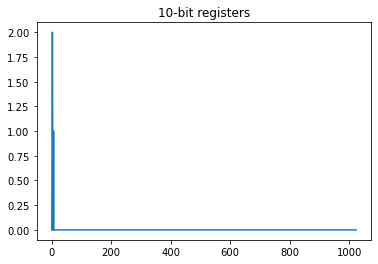

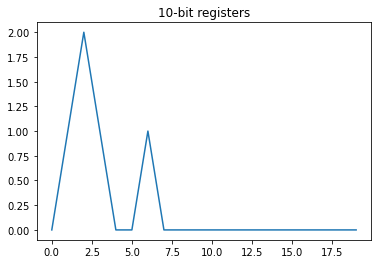

In [71]:
import matplotlib.pyplot as plt
plt.figure(); plt.title("10-bit registers")
plt.plot(hll1.registers)
plt.figure(); plt.title("10-bit registers")
plt.plot(hll1.registers[:20])

The cardinality of this sequence is given by the function estimate_sequence_cardinality(). This function applies the harmonic mean 2**N, where N are the registers from HyperLogLog.

In [72]:
print("Cardinality:")
print(hll1.estimate_sequence_cardinality(sequence=seq1, k=k, num_registers=1024))

Cardinality:
4.007832904843586


### 8. Analysis of an example 2

Explanation of the HyperLogLog cardinality estimation with the 9th sequence (shortest sequence)

In [73]:
hll2 = Hyperloglog(1024)
seq2 = sequences[8]
k = 5
num_registers = 1024
sketch = hll2.create_hll_sketch(sequence=seq2, k=k, num_registers=num_registers)
cardinality = hll2.estimate_sequence_cardinality(sequence=seq2, k=k, num_registers=num_registers)

kmers = [seq2[i:i+k] for i in range(len(seq2) - k+1)]

encoded_kmers = []
hash_values = []
binary_values = []
register_indices = []

for kmer in kmers:
    # Encode k-mer
    encoded_kmer = int.from_bytes(kmer.encode('utf-8'), byteorder='big')
    encoded_kmers.append(encoded_kmer)
    
    # Hash the k-mer
    hash_value = hll2.hash_ThomasWang64(encoded_kmer)
    hash_values.append(hash_value)
    
    # Convert hash value to binary
    binary_value = bin(hash_value)[2:]
    binary_values.append(binary_value)
    
    # Determine register index based on trailing zeros
    register_index = hll2.hash_to_binary(hash_value)
    register_indices.append(register_index)

    # trailing zeros
    trailing_zero = hll2.count_trailing_zeros(hash_value)
    trailing_zeros.append(trailing_zero)
    
    # Update registers (if needed)
    hll2.registers[register_index] = max(hll2.registers[register_index], hll2.count_trailing_zeros(hash_value))
    
df_example2 = pd.DataFrame(columns=["kmer", "enconded_kmer", "hashed_kmer", "binary_value", "register_index"])
df_example2.kmer = kmers
df_example2.enconded_kmer = encoded_kmers
df_example2.hashed_kmer = hash_values
df_example2.binary_value = binary_values
df_example2.register_index = register_indices
display(df_example2)
import numpy as np
np.unique(df_example2.register_index)

,kmer,enconded_kmer,hashed_kmer,binary_value,register_index
0,ATGTA,280586835009,4467535806820806584,1111011111111111100000001001010111001011100100...,3
1,TGTAT,361973956948,8468507349194880504,1110101100001100010111010010000111001101000101...,3
2,GTATT,306356245588,7582004078052828889,1101001001110001011000010001001101011011110011...,0
3,TATTG,361873298503,17676505246219196408,1111010101001111100011111101111000000111001110...,3
4,ATTGT,280587683668,5915550977267011560,1010010000110000100001001000101100110101011011...,3
...,...,...,...,...,...
309,CTTAG,289177616711,4135341170862714864,1110010110001110101110111000101000101001010001...,4
310,TTAGT,362190817108,3670204734205862641,1100101110111100101111110000101001101101001100...,0
311,TAGTT,361872446548,16248783568612666422,1110000101111111010001101001000011011111010111...,1
312,AGTTG,280369583175,1953052142594529392,1101100011010101000101001001101110011001010011...,4


array([ 0,  1,  2,  3,  4,  5,  6, 12], dtype=int64)

In this case, three instances had trainling zeros: two, one and three, as seen the plot bellow.

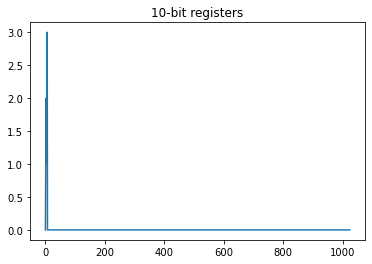

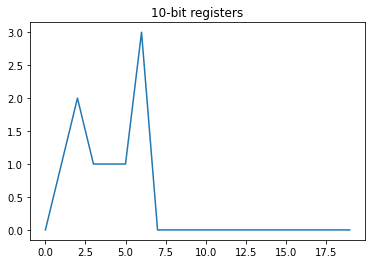

In [74]:
plt.figure(); plt.title("10-bit registers")
plt.plot(hll2.registers)
plt.figure(); plt.title("10-bit registers")
plt.plot(hll2.registers[:20])

The cardinality of this sequence is given by the function estimate_sequence_cardinality(). This function applies the harmonic mean 2**N, where N are the registers from HyperLogLog.

In [75]:
print("Cardinality of example 2:")
print(hll2.estimate_sequence_cardinality(sequence=seq2, k=k, num_registers=1024))

Cardinality of example 2:
6.01764709272061


### 9. Pros and cons of the approach

**Dashing: Pros and Cons Compared to Other Tools**

**1. Accuracy and Efficiency:**
   - **Pros:**
     - Dashing demonstrates high accuracy with smaller sketches, justifying a lower default sketch size (1 kb) compared to other tools.
     - The use of HyperLogLog (HLL) with Maximum Likelihood Estimator (MLE) and Joint MLE contributes to accurate genomic distance estimations.
     - Efficiently performs sketching and pairwise distance calculations for over 87K Refseq genomes in approximately 6 minutes.
     - Dashing's speed advantage is particularly evident in the sketching phase, where it outperforms other tools.
     - Achieves excellent thread scaling in both the sketching and distance estimation phases.

   - **Cons:**
     - Slower than BinDash at distance calculations due to the relatively expensive nature of distance calculation between two HLL sketches.
     - The computational cost of distance calculations involves exponentiations, divisions, and iterative procedures, impacting overall speed.

**2. Sketching Phase:**
   - **Pros:**
     - Dashing's sketching phase is notably fast, running 3.3–4.3 times faster than BinDash and 3.8–5.0 times faster than Mash.
     - The ability to re-sketch from scratch is almost as fast as loading pre-made sketches from disk.

   - **Cons:**
     - The memory footprint in the sketching phase is higher compared to BinDash, especially for larger sketch sizes.

**3. Distance Phase:**
   - **Pros:**
     - BinDash is the fastest tool in the distance phase, running 25–70% faster than Dashing's MLE mode.
     - Dashing remains faster than Mash in the distance phase, with the largest speed gap observed at the smallest (1 kb) sketch size.
   - **Cons:**
     - Dashing exhibits a major speed difference in distance calculations based on the estimation method used, with Joint MLE being slower.

**4. Memory Footprint:**
   - **Pros:**
     - BinDash achieves the lowest memory footprint in both sketching and distance phases, requiring less memory (always below 6 GB).
     - Dashing's memory footprint is moderate, ranging from 12 to 18 GB.
     - Mash has the highest memory footprint among the three tools, ranging from 17 to 25 GB.

   - **Cons:**
     - Dashing's memory footprint is higher compared to BinDash, especially for larger sketch sizes.

**5. Features and Flexibility:**
   - **Pros:**
     - Dashing supports several features not present in Mash or BinDash, including spaced seeds, various output formats, asymmetric distances, and hash-set-based mode for exact Jaccard coefficients.
     - Dashing contains its own implementation of MinHash and b-Bit, providing flexibility for various situations.

   - **Cons:**
     - Limited information about specific features and capabilities of BinDash and Mash for a detailed comparison.

**6. Cardinality Estimation Methods:**
   - **Pros:**
     - Dashing supports three cardinality estimation methods: Flajolet’s canonical method (“Original”), Ertl’s Maximum Likelihood Estimator (“Ertl-MLE”), and Ertl’s joint MLE (“Ertl-JMLE”).
     - Ertl-MLE is chosen as Dashing's default due to a balance between speed and accuracy.

   - **Cons:**
     - Joint MLE method performs significantly more calculations, making it slower, although it provides the most accurate results.

**7. Thread Scaling:**
   - **Pros:**
     - Dashing exhibits excellent thread scaling in both sketching and distance estimation phases compared to Mash and BinDash.

   - **Cons:**
     - Limited information on the thread scaling capabilities of BinDash and Mash for a detailed comparison.

**8. Tool Comparison:**
   - **Pros:**
     - Dashing is positioned as the fastest tool overall, particularly for sketching and combined sketching-and-distance calculations in typical situations.
     - BinDash achieves similar speed to Dashing at the largest (64 kb) sketch size but maintains a lower memory footprint.
     - Mash is the slowest among the three tools in all cases.

   - **Cons:**
     - Limited information on specific features, capabilities, and performance metrics of BinDash and Mash for a comprehensive comparison.

**9. Future Directions and Considerations:**
   - **Pros:**
     - Dashing explores potential extensions for handling multiplicities and incorporating tf-idf weighting for HLL.
     - The unused portion (25%) of each HLL register in Dashing could be utilized for an auxiliary Bloom filter, potentially improving accuracy for low-cardinality sets.

   - **Cons:**
     - The trade-off between accuracy and computational cost is highlighted, particularly in the distance calculation phase.



### 10. Future improvements

**Future Improvements for Dashing:**

1. **Enhanced Distance Calculation Efficiency:**
   - Investigate optimization strategies for distance calculations between HLL sketches to improve computational efficiency.
   - Explore parallelization and vectorization techniques to accelerate distance calculations and reduce processing time.

2. **Optimized Cardinality Estimation Methods:**
   - Continue research on cardinality estimation methods to strike a balance between speed and accuracy.
   - Explore potential improvements in the Joint MLE method to make it more computationally efficient without sacrificing accuracy.

3. **Sparse Representation Utilization:**
   - Investigate the feasibility of exploiting sparsity in input datasets to enhance computational efficiency where applicable.
   - Develop strategies to handle sparse data effectively, considering scenarios where input sets have few elements compared to the number of HLL registers.

4. **Multiplicity-Preserving Extensions:**
   - Explore extensions to Dashing that preserve multiplicities, similar to efforts made for MinHash (e.g., Finch, BagMinHash, SuperMinHash).
   - Investigate methods to incorporate information about multiplicities, especially beneficial for handling repetitive DNA and improving accuracy in genomic distance measurements.

5. **Utilization of Unused HLL Register Bits:**
   - Research and experiment with ways to utilize the unused portion (25%) of each HLL register.
   - Consider employing this unused space to implement auxiliary data structures, such as a striped Bloom filter, to potentially improve accuracy for specific types of data.

6. **Sparse Data Handling:**
   - Further investigate and refine Dashing's ability to handle sparse data efficiently.
   - Evaluate scenarios where sparse representation assumptions are valid and implement optimizations to capitalize on sparsity, potentially reducing memory requirements.

7. **Extension to Other Applications:**
   - Generalize or extend Dashing to cater to applications beyond genomics, such as text document comparisons based on n-grams or image comparisons using extracted features.
   - Explore adaptability to diverse data types and domains, expanding the tool's utility beyond genomics.

8. **User Interface and Interactivity:**
   - Enhance user interface features to provide a more interactive and user-friendly experience.
   - Implement visualization tools to help users better understand the results, clusters, and relationships uncovered by Dashing.

9. **Benchmarking and Comparative Studies:**
   - Conduct extensive benchmarking studies to compare Dashing against emerging tools and technologies in genomics and bioinformatics.
   - Collaborate with the research community to establish standardized benchmarks for genomic distance calculations and sketching methods.

10. **Documentation and Educational Resources:**
    - Improve documentation to provide comprehensive guidance on Dashing's features, functionalities, and optimal usage.
    - Develop educational resources, tutorials, and examples to assist users in understanding the tool's capabilities and leveraging it effectively for their specific analyses.

11. **Community Collaboration:**
    - Foster an active user community around Dashing, encouraging collaboration, feedback, and contributions.
    - Establish channels for communication and support, including forums, mailing lists, and community-driven development initiatives.

12. **Integration with Workflow Tools:**
    - Explore integration possibilities with popular bioinformatics workflow tools to streamline the inclusion of Dashing in larger analytical pipelines.
    - Provide compatibility and interoperability with commonly used data formats and bioinformatics platforms.

13. **Fine-Tuning Hyperparameters:**
    - Allow users to fine-tune hyperparameters to adapt Dashing to specific use cases and datasets.
    - Provide guidance and best practices for selecting optimal hyperparameter values based on the nature of the data being analyzed.

14. **Continuous Optimization and Maintenance:**
    - Establish a system for continuous optimization and maintenance of Dashing to address bugs, enhance performance, and adapt to evolving computational environments.
    - Regularly release updates with improvements based on user feedback and advancements in genomics and bioinformatics research.


### 11. References
[1] Cheng-Wei Hu. *HyperLogLog: A Simple but Powerful Algorithm for Data Scientists*. January 04, 2021.
</br>
[2] D. N. Baker and B. Langmead, “Dashing: fast and accurate genomic distances with HyperLogLog,” Genome Biology, vol. 20, no. 1. Springer Science and Business Media LLC, Dec. 2019. doi: 10.1186/s13059-019-1875-0.

[3] https://users.cs.utah.edu/~pandey/courses/cs6968/spring23/papers/dashing2.pdf

"Dashing 2: genomic sketching with multiplicities and
locality-sensitive hashing" by Daniel N. Baker1 and Ben Langmead1,

[4] https://genome.cshlp.org/content/early/2023/07/06/gr.277655.123.full.pdf

"Genomic sketching with multiplicities and locality-sensitive
2 hashing using Dashing 2" by Daniel N. Baker1 and Ben Langmead1